In [5]:
import re
import gc
from datetime import datetime
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
from scipy.stats import mode
import scipy.stats as stats
from sklearn.tree import export_graphviz
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
import lightgbm as lgb
from lightgbm import plot_importance
import warnings
warnings.filterwarnings('ignore')

In [16]:
df_train = pd.read_csv("./input/train_users_2.csv")
df_test = pd.read_csv("./input/test_users.csv")
df_countries = pd.read_csv('./input/countries.csv')
df_sessions = pd.read_csv('./input/sessions.csv')
df_age_bkts = pd.read_csv('./input/age_gender_bkts.csv')

In [17]:
df_all = pd.concat([df_train, df_test], axis=0)
train_id = df_train.id
test_id = df_test.id
all_id = df_all.id

# Processing Dates in all Dataframes

In [18]:
timestamp = df_all.timestamp_first_active.astype(str).apply(lambda x: datetime(int(x[:4]),
                                                                          int(x[4:6]), 
                                                                          int(x[6:8]),
                                                                          int(x[8:10]),
                                                                          int(x[10:12]),
                                                                          int(x[12:])))

df_all['active_year'] = np.array([date.year for date in timestamp])
df_all['active_month'] = np.array([date.month for date in timestamp])
df_all['active_day'] = np.array([date.day for date in timestamp])

In [19]:
df_all["date_account_created"] = pd.to_datetime(df_all["date_account_created"], format = "%Y-%m-%d")

df_all['create_year'] = df_all["date_account_created"].apply(lambda x : x.year)
df_all['create_month'] = df_all["date_account_created"].apply(lambda x : x.month)
df_all['create_day'] = df_all["date_account_created"].apply(lambda x : x.day)

In [20]:
#this will help us get the time interval feature
df_all["timestamp_first_active"] = pd.to_datetime(df_all["timestamp_first_active"], format="%Y%m%d%H%M%S")
time_interval = df_all["timestamp_first_active"] - df_all["date_account_created"]

In [21]:
df_all["interval_days"] = time_interval.apply(lambda x : -1 * x.days)
df_all["interval_seconds"] = np.log(time_interval.apply(lambda x : x.seconds))

In [22]:
def holidays_check(year):
    
    response = requests.get("https://www.timeanddate.com/calendar/custom.html?year="+str(year)+"                                &country=1&cols=3&df=1&hol=25")
    dom = BeautifulSoup(response.content, "html.parser")

    trs = dom.select("table.cht.lpad tr")

    df = pd.DataFrame(columns=["date", "holiday"])
    for tr in trs:
        datestr = tr.select_one("td:nth-of-type(1)").text
        date = datetime.strptime("{} {}".format(year, datestr), '%Y %b %d')
        holiday = tr.select_one("td:nth-of-type(2)").text
        df.loc[len(df)] = {"date" : date, "holiday": 1}
    print(df.head()) #print holiday dates
    return df

list_of_hols = []

for year in range(2009, 2014):
    df = holidays_check(year)
    list_of_hols.append(df)
    holidays = pd.concat(list_of_hols)
    
select_date = list(holidays["date"].astype("str"))
holiday = df_all.timestamp_first_active.apply(lambda x : str(x.date())).isin(select_date)

df_all["holiday"] = holiday #stored as True or False values
df_all["holiday"] = df_all['holiday'].apply(lambda x : 1 if x else 0)

        date holiday
0 2009-01-01       1
1 2009-01-19       1
2 2009-02-14       1
3 2009-02-16       1
4 2009-03-17       1
        date holiday
0 2010-01-01       1
1 2010-01-18       1
2 2010-02-14       1
3 2010-02-15       1
4 2010-03-17       1
        date holiday
0 2011-01-01       1
1 2011-01-17       1
2 2011-02-14       1
3 2011-02-21       1
4 2011-03-17       1
        date holiday
0 2012-01-01       1
1 2012-01-02       1
2 2012-01-16       1
3 2012-02-14       1
4 2012-02-20       1
        date holiday
0 2013-01-01       1
1 2013-01-21       1
2 2013-02-14       1
3 2013-02-18       1
4 2013-03-17       1


In [26]:
df_all['holiday'].head()

0    0
1    0
2    0
3    1
4    0
Name: holiday, dtype: int64

In [27]:
weekday = df_all.filter(items=['id','timestamp_first_active'])
weekday = pd.to_datetime(weekday["timestamp_first_active"], format="%Y-%m-%d")
weekday = weekday.dt.dayofweek

df_all["weekend"] = weekday.apply(lambda x : 1 if x>=5 else 0)


In [28]:
df_all = df_all.drop("date_account_created" , axis=1)
df_all = df_all.drop("timestamp_first_active" , axis=1)

In [29]:
df_all = df_all.drop("date_first_booking", axis=1)

In [30]:
df_all["first_affiliate_tracked"] = df_all["first_affiliate_tracked"].replace(np.nan, "untracked")

# Age 

### Dataframe before processing (outliers)

In [59]:
df_train[df_train.age > 100].head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
388,v2x0ms9c62,2010-04-11,20100411065602,2010-04-13,-unknown-,2014.0,basic,3,en,other,craigslist,untracked,Web,Windows Desktop,Firefox,FR
398,9ouah6tc30,2010-04-12,20100412231534,2010-04-12,FEMALE,104.0,facebook,3,en,other,craigslist,linked,Web,iPhone,Mobile Safari,FR
627,dc3udjfdij,2010-05-19,20100519012455,2010-06-16,-unknown-,105.0,basic,2,en,other,craigslist,omg,Web,Mac Desktop,Safari,FR
673,umf1wdk9uc,2010-05-25,20100525155541,NaN,FEMALE,2014.0,basic,2,en,other,craigslist,untracked,Web,Mac Desktop,Safari,NDF
1040,m82epwn7i8,2010-07-14,20100714230556,2010-07-15,MALE,2014.0,facebook,0,en,other,craigslist,untracked,Web,Mac Desktop,Chrome,US


In [31]:
def process_age(users):
    ''' Function takes in the user data frame and cleans ages.'''
    
    #Assume ages > year 1930 are the year born of people. Derive ages from that year
    users['age'] = users['age'].apply(lambda x: x-2014 if x > 1920 else x)
    
    #take away age outliers > 10 or < 13
    users['age'] = users['age'].apply(lambda x: np.nan if x > 100 or x < 13 else x)
    
    return users

df_all = process_age(df_all)

### Dataframe after processing (no outliers)

In [56]:
df_all[df_all.age > 100]

,age,country_destination,id,signup_flow,create_year,create_month,create_day,active_year,active_month,active_day,holiday,weekend,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Arora,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CometBird,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IBrowse,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_Nintendo Browser,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,language_-unknown-,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,gender


In [32]:
def get_age(age):
    if age < 0:
        return 'NAN'
    elif (np.logical_and(age<25, age>=15)):
        return 20
    elif (np.logical_and(age<35, age>=25)):
        return 30 
    elif (np.logical_and(age<45, age>=35)):
        return 40
    elif (np.logical_and(age<55, age>=45)):
        return 50
    elif (np.logical_and(age<65, age>=55)):
        return 60
    elif (np.logical_and(age<75, age>=65)):
        return 70
    elif (np.logical_and(age<85, age>=75)):
        return 80
    
    
age = df_all.age
df_all['age'] = np.array([get_age(x) for x in age])

#### Binned ages

In [61]:
df_all['age'].head()

0    None
1      40
2      60
3      40
4      40
Name: age, dtype: object

# Deriving Gender with LGB Classification

In [33]:
df_age = df_all.filter(items = ['age', 'country_destination','id', 'gender'])
df_dummy = df_all.filter(items = ['affiliate_channel', 'affiliate_provider',
                                       'first_affiliate_tracked', 'first_browser', 'first_device_type',
                                       'language', 'signup_app', 'signup_flow', 'signup_method', 
                                       'create_year', 'create_month', 'create_day', 
                                       'active_year', 'active_month', 'active_day', 'lag_days', 'lag_seconds', 
                                       'holiday', 'weekend'])
    
df_dummy = pd.get_dummies(df_dummy)
df_all = pd.concat([df_age, df_dummy], axis=1)

In [34]:
df_all["gender"] = df_all["gender"].replace(['-unknown-', 'OTHER'], np.nan)

gender_train = df_all[df_all["gender"].notnull()].reset_index()
gender_test = df_all[df_all["gender"].isnull()].reset_index()

In [35]:
y = gender_train.gender

gender_train_id = gender_train.id
gender_test_id = gender_test.id

gender_train = gender_train.drop(['id', 'age', 'country_destination', 'gender'], axis=1)
gender_test = gender_test.drop(['id', 'age', 'country_destination', 'gender'], axis=1)

In [36]:
X = gender_train

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

model_gender = lgb.LGBMClassifier(n_estimators=500, n_jobs=-1, reg_alpha=1).fit(X_train, y_train)
pred_gender = model_gender.predict(X_test)


In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

model_gender = lgb.LGBMClassifier(n_estimators=500, n_jobs=-1, reg_alpha=1).fit(X_train, y_train)
pred_gender = model_gender.predict(X_test)

pred_gender = model_gender.predict(gender_test)
pred_gender = pd.DataFrame(pred_gender)

In [39]:
#predicted gender
pred_gender = model_gender.predict(gender_test)
pred_gender = pd.DataFrame(pred_gender, columns=['gender'])
pred_gender = pd.concat([pred_gender, gender_test_id], axis=1)

#original gender
origin_gender = y
origin_gender = pd.DataFrame(origin_gender, columns=['gender'])
origin_gender = pd.concat([origin_gender, gender_train_id], axis=1)

#concat original gender and prediction gender
gender = pd.concat([origin_gender, pred_gender], axis=0)

In [40]:
df_all = df_all.drop("gender" , axis=1)

df_all = pd.merge(df_all, gender, on="id", how="left")

In [54]:
print("Current gender count is : " + str(df_all['gender'].count()))
print("Number of observations in dataframe is :" + str(df_all.shape[0]))

Current gender count is : 275547
Number of observations in dataframe is :275547


### Check if there are any more other or Nan gender

In [63]:
df_all['gender'].value_counts()

FEMALE    169330
MALE      106217
Name: gender, dtype: int64

# Session Data

In [72]:
# visualizing sessions data before aggregation
df_sessions.head(20)

,user_id,action,action_type,action_detail,device_type,secs_elapsed
0,d1mm9tcy42,lookup,view,view_search_results,Windows Desktop,319.0
1,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,67753.0
2,d1mm9tcy42,lookup,view,view_search_results,Windows Desktop,301.0
3,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,22141.0
4,d1mm9tcy42,lookup,view,view_search_results,Windows Desktop,435.0
5,d1mm9tcy42,search_results,click,view_search_results,Windows Desktop,7703.0
6,d1mm9tcy42,lookup,view,view_search_results,Windows Desktop,115.0
7,d1mm9tcy42,personalize,data,wishlist_content_update,Windows Desktop,831.0
8,d1mm9tcy42,index,view,view_search_results,Windows Desktop,20842.0
9,d1mm9tcy42,lookup,view,view_search_results,Windows Desktop,683.0


In [64]:
def make_merged_sessions():
    
    sessions = df_sessions

    #session elapsed group by sum, mean
    ses = sessions.filter(items=('user_id', 'secs_elapsed'))
     
    print(" Group aggregation in process...")

        
    ses_groupby_sum = ses.groupby("user_id").agg(np.sum)
    ses_groupby_mean = ses.groupby("user_id").agg(np.mean)
    ses_groupby_median = ses.groupby("user_id").agg(np.median)
    ses_groupby_var = ses.groupby("user_id").agg(np.var)
    
    #fill null data with mode value
    sessions["action"] = sessions["action"].fillna("show")
    sessions["action_type"] = sessions["action_type"].fillna("view")
    sessions["action_detail"] = sessions["action_detail"].fillna("view_search_results")
    
    id_groupby = sessions.groupby(sessions["user_id"]).agg(mode)
    
    device_type = []
    action = []
    action_type = []
    action_detail = []
    secs_elapsed = []

    for i in range(len(id_groupby.index)):
        device_type.append(id_groupby['device_type'][i][0])
        action.append(id_groupby['action'][i][0])
        action_type.append(id_groupby['action_type'][i][0])
        action_detail.append(id_groupby['action_detail'][i][0])
        secs_elapsed.append(id_groupby['secs_elapsed'][i][0])
    
    id_groupby_df = pd.DataFrame({"id":id_groupby.index ,
                                  "device_type":device_type ,
                                  "action":action,
                                  "action_type":action_type,
                                  "action_detail":action_detail,
                                  "secs_elapsed":secs_elapsed
                                  })
    
     
    print("Merging sessions...")
    
    merge_ses_groupby = pd.merge(ses_groupby_sum, ses_groupby_mean, left_index=True, right_index=True, how="left")
    merge_ses_groupby = pd.merge(merge_ses_groupby, ses_groupby_median, left_index=True, right_index=True, how="left")
    merge_ses_groupby = pd.merge(merge_ses_groupby, ses_groupby_var, left_index=True, right_index=True, how="left")
    
    merged_sessions = pd.merge(id_groupby_df, merge_ses_groupby, left_on="id", right_index=True, how="left")
    
    merged_sessions['secs_elapsed'] = merged_sessions['secs_elapsed'].astype(float)
    
    merged_sessions.fillna(0)
#     merged_sessions['secs_mean'] = merged_sessions['secs_mean'].fillna(0)
#     merged_sessions['secs_mean'] = merged_sessions['secs_mean'].fillna(0)
    return merged_sessions

In [65]:
%%time
merged_sessions = make_merged_sessions()

 Group aggregation in process...
Merging sessions...
Wall time: 4min 35s


In [67]:
merged_sessions.columns = ['id', 'device_type', 'action', 'action_type', 'action_detail',
       'secs_elapsed', 'secs_sum', 'secs_mean', 'secs_median',
       'secs_var']

### Merged sessions aggregation values + action grouped

In [73]:
merged_sessions.head()

,id,device_type,action,action_type,action_detail,secs_elapsed,secs_sum,secs_mean,secs_median,secs_var
0,00023iyk9l,[Mac Desktop],[show],[view],[view_search_results],820.0,867896.0,22253.743590,850.0,8.508690e+09
1,0010k6l0om,[Mac Desktop],[show],[view],[view_search_results],125.0,586543.0,9460.370968,948.5,5.176184e+08
2,001wyh0pz8,[Android App Unknown Phone/Tablet],[search],[click],[view_search_results],623.0,282965.0,3179.382022,1105.0,4.316028e+07
3,0028jgx1x1,[-unknown-],[show],[view],[p3],3.0,297010.0,9900.333333,1614.0,3.241787e+08
4,002qnbzfs5,[iPhone],[show],[view],[view_search_results],1.0,6487080.0,8232.335025,498.0,3.376847e+09


In [74]:
def sessions_detail_add(merged_sessions):
    sessions = df_sessions
    print("groupby count in process...")
    tmp = sessions.groupby(["user_id", "action_type"])["device_type"].count().unstack().fillna(0)
    sessions_at = pd.DataFrame(tmp)
    sessions_at.rename(columns = lambda x : "count_type__" + x, inplace = True)

    tmp = sessions.groupby(["user_id", "action"])["device_type"].count().unstack().fillna(0)
    sessions_a = pd.DataFrame(tmp)
    sessions_a.rename(columns = lambda x : "count_action__" + x, inplace = True)

    tmp = sessions.groupby(["user_id", "action_detail"])["device_type"].count().unstack().fillna(0)
    sessions_ad = pd.DataFrame(tmp)
    sessions_ad.rename(columns = lambda x : "count_detail__" + x, inplace = True)

    df_session_info = sessions_at.merge(sessions_a, how = "outer", left_index = True, right_index = True)
    df_session_info = df_session_info.merge(sessions_ad, how = "left", left_index = True, right_index = True)

    df_session_info.drop(["count_type__-unknown-", "count_detail__-unknown-"], axis = 1, inplace = True)
    df_session_info = df_session_info.fillna(0)

    print("merge sessions in process...")
    
    last_merged_sessions = pd.merge(merged_sessions, df_session_info, left_on='id', right_index=True, how='left')

    return last_merged_sessions
    
def remove_word(merged_sessions):


    def remove(word):
        word = re.sub("''", "", word)
        word = re.sub("\W", "", word)
        return word

    merged_sessions["action"] = merged_sessions["action"].apply(lambda x: remove(x[0]))
    merged_sessions["action_detail"] = merged_sessions["action_detail"].apply(lambda x: remove(x[0]))
    merged_sessions["action_type"] = merged_sessions["action_type"].apply(lambda x: remove(x[0]))
    merged_sessions["device_type"] = merged_sessions["device_type"].apply(lambda x: remove(x[0]))


    merged_sessions["action_detail"] = merged_sessions["action_detail"].replace({"['-unknown-']":"unknown"})
    merged_sessions["action_type"] = merged_sessions["action_type"].replace({"['-unknown-']":"unknown"})
    merged_sessions["device_type"] = merged_sessions["device_type"].replace({"['-unknown-']":"unknown", "['Android App Unknown Phone/Tablet']": "Android_unknown_phone"})

    return merged_sessions

In [75]:
merged_sessions = remove_word(merged_sessions)
merged_sessions = sessions_detail_add(merged_sessions)

groupby count in process...
merge sessions in process...


In [76]:
merged_sessions.head()

,id,device_type,action,action_type,action_detail,secs_elapsed,secs_sum,secs_mean,secs_median,secs_var,count_type__booking_request,count_type__booking_response,count_type__click,count_type__data,count_type__message_post,count_type__modify,count_type__partner_callback,count_type__submit,count_type__view,count_action__10,count_action__11,count_action__12,count_action__15,count_action__about_us,count_action__accept_decline,count_action__account,count_action__acculynk_bin_check_failed,count_action__acculynk_bin_check_success,count_action__acculynk_load_pin_pad,count_action__acculynk_pin_pad_error,count_action__acculynk_pin_pad_inactive,count_action__acculynk_pin_pad_success,count_action__acculynk_session_obtained,count_action__active,count_action__add_business_address_colorbox,count_action__add_guest_colorbox,count_action__add_guests,count_action__add_note,count_action__agree_terms_check,count_action__agree_terms_uncheck,count_action__airbnb_picks,count_action__airbrb,count_action__ajax_check_dates,count_action__ajax_get_referrals_amt,count_action__ajax_get_results,count_action__ajax_google_translate,count_action__ajax_google_translate_description,count_action__ajax_google_translate_reviews,count_action__ajax_image_upload,count_action__ajax_ldp,count_action__ajax_lwlb_contact,count_action__ajax_payout_edit,count_action__ajax_payout_options_by_country,count_action__ajax_payout_split_edit,count_action__ajax_photo_widget,count_action__ajax_photo_widget_form_iframe,count_action__ajax_price_and_availability,count_action__ajax_referral_banner_experiment_type,count_action__ajax_referral_banner_type,count_action__ajax_refresh_subtotal,count_action__ajax_send_message,count_action__ajax_special_offer_dates_available,count_action__ajax_statsd,count_action__ajax_worth,count_action__apply,count_action__apply_code,count_action__apply_coupon_click,count_action__apply_coupon_click_success,count_action__apply_coupon_error,count_action__apply_coupon_error_type,count_action__apply_reservation,count_action__approve,count_action__ask_question,count_action__at_checkpoint,count_action__authenticate,count_action__authorize,count_action__available,count_action__badge,count_action__become_user,count_action__book,count_action__booking,count_action__braintree_client_token,count_action__business_travel,count_action__calendar_tab_inner2,count_action__callback,count_action__campaigns,count_action__cancel,count_action__cancellation_policies,count_action__cancellation_policy_click,count_action__change,count_action__change_availability,count_action__change_currency,count_action__change_default_payout,count_action__change_password,count_action__check,count_action__city_count,count_action__clear_reservation,count_action__click,count_action__clickthrough,count_action__collections,count_action__complete,count_action__complete_redirect,count_action__complete_status,count_action__concierge,count_action__confirm_email,count_action__confirmation,count_action__connect,count_action__contact_new,count_action__countries,count_action__country_options,count_action__coupon_code_click,count_action__coupon_field_focus,count_action__create,count_action__create_ach,count_action__create_airbnb,count_action__create_multiple,count_action__create_paypal,count_action__currencies,count_action__custom_recommended_destinations,count_action__dashboard,count_action__deactivate,count_action__deactivated,count_action__deauthorize,count_action__decision_tree,count_action__delete,count_action__department,count_action__departments,count_action__desks,count_action__destroy,count_action__detect_fb_session,count_action__disaster_action,count_action__domains,count_action__edit,count_action__edit_verification,count_action__email_by_key,count_action__email_itinerary_colorbox,count_action__email_share,count_action__email_wishlist,count_action__endpoint_error,count_action__envoy_bank_details_redirect,count_action__envoy_form,count_action__events,count_action__facebook_auto_login,count_action__faq,count_act

In [77]:
gc.collect()

129

## Merging User and Sessions dataframe based on ID

In [78]:
df_all = pd.merge(df_all, merged_sessions, on="id", how="left")
df_all.head()

,age,country_destination,id,signup_flow,create_year,create_month,create_day,active_year,active_month,active_day,holiday,weekend,affiliate_channel_api,affiliate_channel_content,affiliate_channel_direct,affiliate_channel_other,affiliate_channel_remarketing,affiliate_channel_sem-brand,affiliate_channel_sem-non-brand,affiliate_channel_seo,affiliate_provider_baidu,affiliate_provider_bing,affiliate_provider_craigslist,affiliate_provider_daum,affiliate_provider_direct,affiliate_provider_email-marketing,affiliate_provider_facebook,affiliate_provider_facebook-open-graph,affiliate_provider_google,affiliate_provider_gsp,affiliate_provider_meetup,affiliate_provider_naver,affiliate_provider_other,affiliate_provider_padmapper,affiliate_provider_vast,affiliate_provider_wayn,affiliate_provider_yahoo,affiliate_provider_yandex,first_affiliate_tracked_linked,first_affiliate_tracked_local ops,first_affiliate_tracked_marketing,first_affiliate_tracked_omg,first_affiliate_tracked_product,first_affiliate_tracked_tracked-other,first_affiliate_tracked_untracked,first_browser_-unknown-,first_browser_AOL Explorer,first_browser_Android Browser,first_browser_Apple Mail,first_browser_Arora,first_browser_Avant Browser,first_browser_BlackBerry Browser,first_browser_Camino,first_browser_Chrome,first_browser_Chrome Mobile,first_browser_Chromium,first_browser_CometBird,first_browser_Comodo Dragon,first_browser_Conkeror,first_browser_CoolNovo,first_browser_Crazy Browser,first_browser_Epic,first_browser_Firefox,first_browser_Flock,first_browser_Google Earth,first_browser_Googlebot,first_browser_IBrowse,first_browser_IE,first_browser_IE Mobile,first_browser_IceDragon,first_browser_IceWeasel,first_browser_Iron,first_browser_Kindle Browser,first_browser_Maxthon,first_browser_Mobile Firefox,first_browser_Mobile Safari,first_browser_Mozilla,first_browser_NetNewsWire,first_browser_Nintendo Browser,first_browser_OmniWeb,first_browser_Opera,first_browser_Opera Mini,first_browser_Opera Mobile,first_browser_Outlook 2007,first_browser_PS Vita browser,first_browser_Pale Moon,first_browser_Palm Pre web browser,first_browser_RockMelt,first_browser_Safari,first_browser_SeaMonkey,first_browser_Silk,first_browser_SiteKiosk,first_browser_SlimBrowser,first_browser_Sogou Explorer,first_browser_Stainless,first_browser_TenFourFox,first_browser_TheWorld Browser,first_browser_UC Browser,first_browser_Yandex.Browser,first_browser_wOSBrowser,first_device_type_Android Phone,first_device_type_Android Tablet,first_device_type_Desktop (Other),first_device_type_Mac Desktop,first_device_type_Other/Unknown,first_device_type_SmartPhone (Other),first_device_type_Windows Desktop,first_device_type_iPad,first_device_type_iPhone,language_-unknown-,language_ca,language_cs,language_da,language_de,language_el,language_en,language_es,language_fi,language_fr,language_hr,language_hu,language_id,language_is,language_it,language_ja,language_ko,language_nl,language_no,language_pl,language_pt,language_ru,language_sv,language_th,language_tr,language_zh,signup_app_Android,signup_app_Moweb,signup_app_Web,signup_app_iOS,signup_method_basic,signup_method_facebook,signup_method_google,signup_method_weibo,gender,device_type,action,action_type,action_detail,secs_elapsed,secs_sum,secs_mean,secs_median,secs_var,count_type__booking_request,count_type__booking_response,count_type__click,count_type__data,count_type__message_post,count_type__modify,count_type__partner_callback,count_type__submit,count_type__view,count_action__10,count_action__11,count_action__12,count_action__15,count_action__about_us,count_action__accept_decline,count_action__account,count_action__acculynk_bin_check_failed,count_action__acculynk_bin_check_success,count_action__acculynk_load_pin_pad,count_action__acculynk_pin_pad_error,count_action__acculynk_pin_pad_inactive,count_action__acculynk_pin_pad_success,count_action__acculynk_session_obtained,count_action__active,count_action__add_business_address_colorbox,count_action__add_guest_colorbox,count_acti

In [79]:
gc.collect()

0

# OHE

In [80]:
target = df_all.country_destination[:213451]

In [82]:
df_all = df_all.drop(["country_destination", "id"], axis=1)
# we do not need these columns for prediction

KeyError: "['country_destination' 'id'] not found in axis"

In [84]:
df_all = pd.get_dummies(df_all)

In [85]:
gc.collect()

113

# Fill null with Median value

In [86]:
%%time
from sklearn.preprocessing import Imputer
impute_list = df_all.columns.tolist()
imp = Imputer(missing_values='NaN', strategy='median', axis=0)

df_all[impute_list] = imp.fit_transform(df_all[impute_list])

gc.collect()

Wall time: 2min 18s


In [87]:
train = df_all[:213451]
test = df_all[213451:]

# train.to_csv("cleaned_train_data.csv")
# test.to_csv("cleaned_test_data.csv")
# target.to_csv("target.csv")


In [88]:
train.isnull().sum()

signup_flow                                  0
create_year                                  0
create_month                                 0
create_day                                   0
active_year                                  0
active_month                                 0
active_day                                   0
holiday                                      0
weekend                                      0
affiliate_channel_api                        0
affiliate_channel_content                    0
affiliate_channel_direct                     0
affiliate_channel_other                      0
affiliate_channel_remarketing                0
affiliate_channel_sem-brand                  0
affiliate_channel_sem-non-brand              0
affiliate_channel_seo                        0
affiliate_provider_baidu                     0
affiliate_provider_bing                      0
affiliate_provider_craigslist                0
affiliate_provider_daum                      0
affiliate_pro

In [89]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213451 entries, 0 to 213450
Columns: 959 entries, signup_flow to action_detail_your_trips
dtypes: float64(959)
memory usage: 1.5 GB


# Machine Learning Code

In [41]:
# test = pd.read_csv("cleaned_test_data.csv", index_col = 0)
# train = pd.read_csv("cleaned_train_data.csv", index_col = 0)
# target = pd.read_csv("target.csv", header = None)

## Main submission file

In [84]:
# target=target.iloc[:, 1]

In [90]:
def submit_kaggle(df_train, df_test, target, reg_alpha, reg_lambda, learning_rate, n_estimators, filename = 'submission_f_select.csv'):
    
    le = LabelEncoder()

    y_train = le.fit_transform(target)
 
    model = lgb.LGBMClassifier(boosting_type= 'gbdt',nthread=3, n_jobs=-1, reg_alpha=reg_alpha, 
                               reg_lambda=reg_lambda, max_depth=-1, learning_rate=learning_rate,
                               n_estimators=n_estimators, seed = 0)

    print("cross validation started ...")
    #negative cross entropy
    print(np.mean(cross_val_score(model, df_train, y_train, n_jobs=-1, )))
    print()
    print("model fitting starting ...")
    
    model = model.fit(df_train, y_train)
       
    print("model fitting completed ...")
    print()
    
    predic_proba = model.predict_proba(df_test)
    
    df_submit = pd.DataFrame(columns=["id", "country"])
    ids = []
    cts = []
    for i in range(len(test_id)):
        idx = test_id.iloc[i]
        ids += [idx] * 5
        cts += le.inverse_transform(np.argsort(predic_proba[i])[::-1])[:5].tolist()
        
    df_submit["id"] = ids
    df_submit["country"] = cts
    df_submit.to_csv(filename, index = False)
    
    gc.collect()
    
    return model, df_train, df_test, target

In [91]:
%%time
fs_model, df_train, df_test, target = submit_kaggle(train, test, target, 
                                                      reg_alpha=1, 
                                                      reg_lambda=0, 
                                                      learning_rate=0.05, 
                                                      n_estimators=400, filename = 'no_fs_submission.csv')

cross validation started ...
0.2701713571010513

model fitting starting ...
model fitting completed ...

Wall time: 10min 51s


## Feature Selection

feature importance mean : 147.18
feature importance median : 0.0


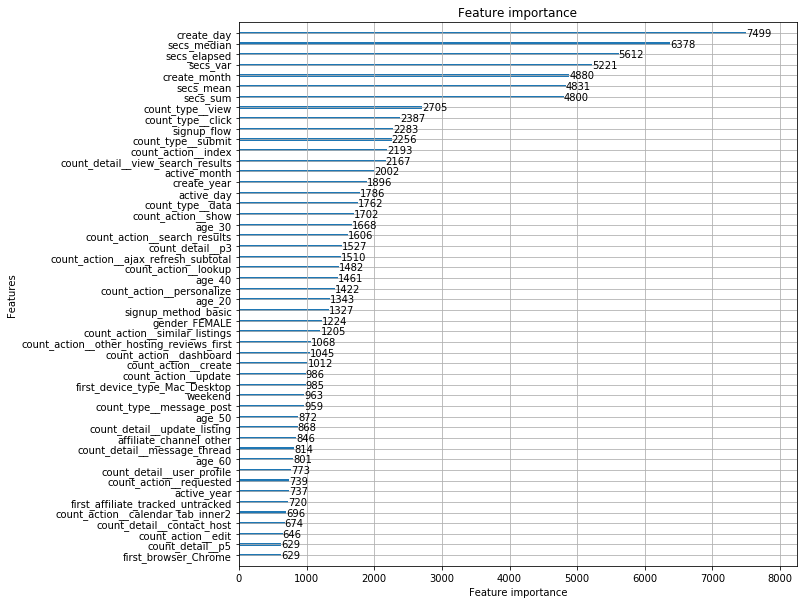

In [93]:
import matplotlib.pyplot as plt
print("feature importance mean :", round(np.mean(fs_model.feature_importances_), 2))
print("feature importance median :", round(np.median(fs_model.feature_importances_), 2))

lgb.plot_importance(fs_model, figsize=(10, 10), max_num_features=50)
plt.show()

In [94]:
fs_model1 = SelectFromModel(fs_model, prefit=True, threshold=1) #treshhold for selection
X_train = fs_model1.transform(df_train)
X_test = fs_model1.transform(df_test)

In [95]:
# pd.DataFrame(X_train).to_csv("cleaned_train_feature_selection.csv", index = False)
# pd.DataFrame(X_test).to_csv("cleaned_test_feature_selection.csv", index = False)

## Main Submission File

In [105]:
feature_reduction = df_all.shape[1] - X_test.shape[1]
print("The number of features has been redcued from " + str(df_all.shape[1]) + " to " + str(X_test.shape[1])
      + "\nCurrent feature count is: " + str(feature_reduction))

The number of features has been redcued from 959 to 451
Current feature count is: 508


In [106]:
%%time

model, df_train, df_test, target = submit_kaggle(X_train, X_test, target, 
                                                      reg_alpha=1, 
                                                      reg_lambda=0, 
                                                      learning_rate=0.1, 
                                                      n_estimators=100, filename = "main_submission.csv")

cross validation started ...
0.2652522297641497

model fitting starting ...
model fitting completed ...

Wall time: 2min 18s


In [108]:
submission_df = pd.read_csv('main_submission.csv')

In [116]:
submission_df.country.value_counts()

US       62095
NDF      62087
other    62085
FR       60031
IT       35388
GB       12567
ES       10157
CA        3917
DE         741
NL         708
PT         380
AU         324
Name: country, dtype: int64

# Further Experimentation

### Hyperparameter Tuning

In [102]:
%%time

model, df_train, df_test, target = submit_kaggle(X_train, X_test, target, 
                                                      reg_alpha=1, 
                                                      reg_lambda=0, 
                                                      learning_rate=0.1, 
                                                      n_estimators=200, filename = "200iterations_submission.csv")

cross validation started ...
0.26923912273130385

model fitting starting ...
model fitting completed ...

Wall time: 5min 9s


### PCA Exploration

In [103]:
from sklearn.decomposition import PCA

pca_trafo_100 = PCA(n_components=100)
pca_data_100 = pca_trafo_100.fit_transform(train)

pca_trafo_200 = PCA(n_components=200)
pca_data_200 = pca_trafo_200.fit_transform(train)

pca_trafo_300 = PCA(n_components=300)
pca_data_300 = pca_trafo_300.fit_transform(train)

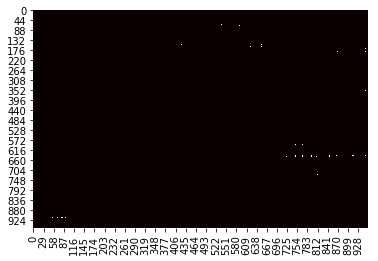

In [57]:
import seaborn as sns
sns.heatmap(np.log(pca_trafo.inverse_transform(np.eye(train.shape[1]))), cmap="hot", cbar=False)


In [60]:
pd.DataFrame(pca_data_100)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-2.296328e+05,-4224.216357,1066.657148,-4.732855,0.724282,-0.351676,-10.836409,0.597511,1.478224,0.195058,...,-0.176653,0.460883,-0.135138,-0.428186,0.128990,0.116080,0.168849,-0.547092,0.476764,-0.149199
1,-2.296328e+05,-4224.216360,1066.657157,-4.736795,0.734944,-0.343176,-11.539709,0.589386,1.510925,0.193926,...,-0.004405,0.066760,0.025689,0.559529,0.006091,-0.134549,0.036613,-0.109576,-0.147833,-0.251196
2,-2.296328e+05,-4224.216411,1066.657259,-4.717030,0.961131,0.011824,-3.766854,0.718234,1.604213,0.592226,...,-0.381630,0.839785,-0.089937,-0.412864,0.419112,0.216055,0.370071,-0.624888,0.789897,-0.643679
3,-2.296328e+05,-4224.216494,1066.657301,-4.838957,0.831996,-0.497451,-3.024680,1.120714,2.335935,0.323542,...,0.390825,-0.866982,0.076476,0.911900,-0.345460,-0.417339,-0.397812,0.608584,-0.737810,1.122330
4,-2.296328e+05,-4224.216524,1066.657269,-4.843778,0.759757,-0.704110,6.860790,1.426559,2.411930,0.314145,...,-0.262167,0.392639,0.012320,0.252180,0.423397,-0.261751,0.083776,0.071161,0.247042,-0.220941
5,-2.296328e+05,-4224.216411,1066.656975,-4.702015,0.436858,-1.021753,20.928969,1.459352,1.408600,0.099265,...,-0.140485,0.298391,-0.054601,-0.617528,0.629991,-0.219234,-0.136797,0.255551,0.568447,0.567462
6,-2.296328e+05,-4224.216406,1066.656980,-4.700389,0.448654,-0.987606,19.517356,1.413951,1.390913,0.103825,...,0.006367,0.125956,-0.003485,-0.239613,0.092677,-0.072156,-0.123082,-0.209224,0.427862,0.455286
7,-2.296328e+05,-4224.216401,1066.656983,-4.699001,0.457198,-0.959801,18.104487,1.367677,1.372056,0.103334,...,-0.110925,0.192857,-0.052725,-0.504691,0.110059,-0.013656,-0.048823,-0.138960,0.383479,0.381865
8,-2.296328e+05,-4224.216396,1066.656986,-4.698032,0.465893,-0.930111,16.691482,1.323336,1.357877,0.104285,...,0.008247,0.127271,-0.020133,-0.283533,0.084871,-0.066104,-0.116168,-0.217677,0.429633,0.458892
9,-2.296328e+05,-4224.216395,1066.656985,-4.698603,0.463547,-0.935079,16.690869,1.323344,1.358265,0.100871,...,-0.099225,0.281187,-0.080565,-0.753510,0.349292,-0.105844,-0.100244,-0.079648,0.538344,0.575008


In [104]:

pca_trafo_100 = PCA(n_components=100)
pca_data_100 = pca_trafo_100.fit_transform(df_all)

pca_trafo_200 = PCA(n_components=200)
pca_data_200 = pca_trafo_200.fit_transform(df_all)

pca_trafo_300 = PCA(n_components=300)
pca_data_300 = pca_trafo_200.fit_transform(df_all)

In [105]:
train_100 = pca_data_100[:213451]
test_100 = pca_data_100[213451:]

In [106]:
train_200 = pca_data_200[:213451]
test_200 = pca_data_200[213451:]

train_300 = pca_data_300[:213451]
test_300 = pca_data_300[213451:]


In [107]:
train_100.shape
test_100.shape

(62096, 100)

# PCA and SVM Testing

In [150]:
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.model_selection import KFold
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.preprocessing import LabelBinarizer

TOL = 1e-4
MAX_ITER = 100
clf = SVC(kernel='linear',
                      max_iter=MAX_ITER,
                      tol=TOL, 
                      random_state=0,
                      decision_function_shape='ovr')



clf.fit(train, target)

y_pred = clf.decision_function(test_100)

def get_top(s):
    indexes = [i for i in range(0,12)]
    lst = list(zip(indexes, s))
    top_five = sorted(lst, key=lambda x: x[1], reverse=True)[:5]
    top_five = [inv_classes[i[0]] for i in top_five]
    return str(top_five)

y_test = y_pred[0]

le = LabelEncoder()

y_train = le.fit_transform(target)

df_submit = pd.DataFrame(columns=["id", "country"])
ids = []
cts = []
for i in range(len(test_id)):
    idx = test_id.iloc[i]
    ids += [idx] * 5
    cts += le.inverse_transform(np.argsort(y_pred[i])[::-1])[:5].tolist()

df_submit["id"] = ids
df_submit["country"] = cts
df_submit.to_csv('svm_linear.csv', index = False)

### PCA + LightGBM Implementation

In [86]:
%%time
model, df_train, df_test, target = submit_kaggle(train_100, test_100, target, 
                                                      reg_alpha=1, 
                                                      reg_lambda=0, 
                                                      learning_rate=0.1, 
                                                      n_estimators=100, filename = 'pca_100.csv')

cross validation started ...
0.393238983511584

model fitting starting ...
model fitting completed ...

Wall time: 3min 8s


In [76]:
#test result for pca_200

model, df_train, df_test, target = submit_kaggle_2(train_200, test_200, target, 
                                                      reg_alpha=1, 
                                                      reg_lambda=0, 
                                                      learning_rate=0.1, 
                                                      n_estimators=100, filename = 'pca_200.csv')

cross validation started ...
0.41338371420185344

model fitting starting ...
model fitting completed ...



In [82]:
%%time

#test result for pca_300

model, df_train, df_test, target = submit_kaggle_2(train_300, test_300, target, 
                                                      reg_alpha=1, 
                                                      reg_lambda=0, 
                                                      learning_rate=0.1, 
                                                      n_estimators=100, filename = 'pca_300.csv')

cross validation started ...
0.4127840308239441

model fitting starting ...
model fitting completed ...

Wall time: 5min 1s


In [86]:
pca_trafo_500 = PCA(n_components=500)
pca_data_500 = pca_trafo_500.fit_transform(df_all)

In [89]:
train_500 = pca_data_500[:213451]
test_500 = pca_data_500[213451:]

In [90]:
%%time

#test result for pca_300

model, df_train, df_test, target = submit_kaggle_2(train_500, test_500, target, 
                                                      reg_alpha=1, 
                                                      reg_lambda=0, 
                                                      learning_rate=0.1, 
                                                      n_estimators=100, filename = 'pca_500.csv')

cross validation started ...
0.42053272700790983

model fitting starting ...
model fitting completed ...

Wall time: 12min 47s


In [91]:
model1 = SelectFromModel(model, prefit=True, threshold=1) #treshhold for selection
train_500_fs = model1.transform(train_500)
test_500_fs = model1.transform(test_500)



model, df_train, df_test, target = submit_kaggle_2(train_500_fs, test_500_fs, target, 
                                                      reg_alpha=1, 
                                                      reg_lambda=0, 
                                                      learning_rate=0.1, 
                                                      n_estimators=100, filename = 'pca_500_fs.csv')

cross validation started ...
0.42053272700790983

model fitting starting ...
model fitting completed ...

